# Clustering jerarquico de series de tiempo utilizando DTW como medida de similaridad
Por: Federico Salinas Samaniego

Carga de librerías

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplcatppuccin
import numpy as np
from pandas import concat

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

from collections import Counter

from Metricas_Clusters import GetMetricsClustering, group_colors

mpl.style.use("mocha")
plt.rcParams.update({
    "text.usetex": True
})

Lecturta de la matriz DTW proveniente de la muestra de series de tiempo

In [2]:
dtw_matrix = np.load("../output data/DTW.npy")

## Fase 3. Clustering Jerarquico

In [3]:
HierClust_Series_Average = AgglomerativeClustering(n_clusters = 3, metric = "precomputed", linkage = "average", compute_distances=True)
HierClust_Series_Average.fit(dtw_matrix)

HierClust_Series_Complete = AgglomerativeClustering(n_clusters = 3, metric = "precomputed", linkage = "complete", compute_distances=True)
HierClust_Series_Complete.fit(dtw_matrix)

HierClust_Series_Single = AgglomerativeClustering(n_clusters = 3, metric = "precomputed", linkage = "single", compute_distances=True)
HierClust_Series_Single.fit(dtw_matrix)

AssignedClusters_Average = HierClust_Series_Average.labels_
AssignedClusters_Complete = HierClust_Series_Complete.labels_
AssignedClusters_Single = HierClust_Series_Single.labels_

print(Counter(AssignedClusters_Average))
print(Counter(AssignedClusters_Complete))
print(Counter(AssignedClusters_Single))

Counter({0: 725, 2: 150, 1: 125})
Counter({2: 541, 0: 275, 1: 184})
Counter({1: 725, 0: 274, 2: 1})


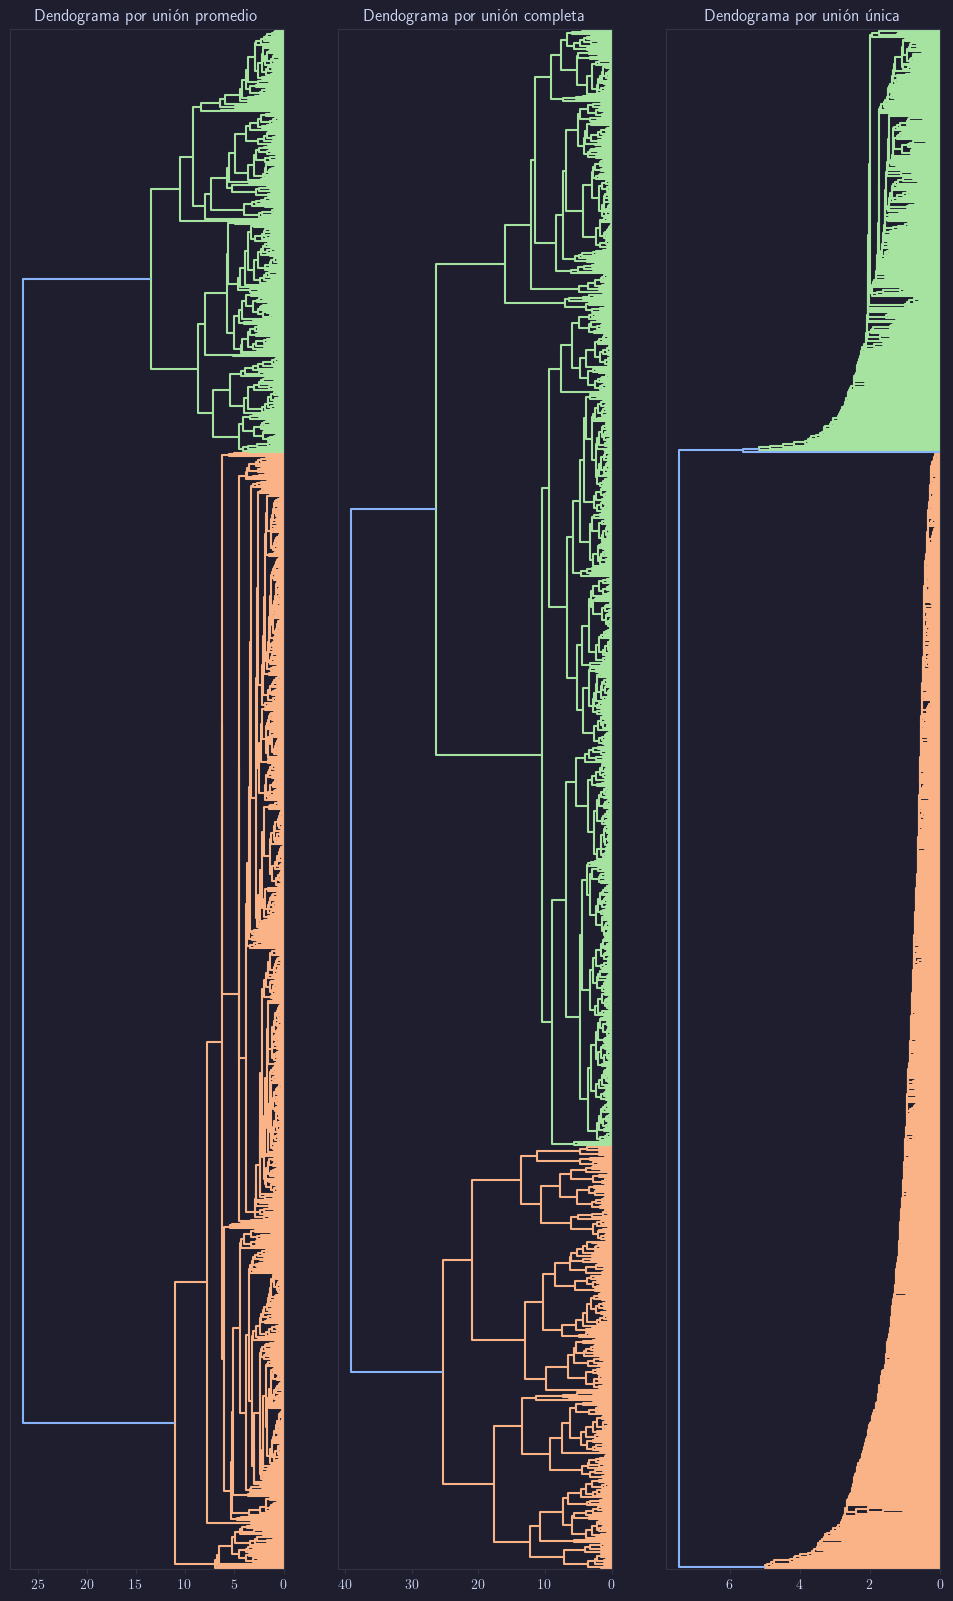

In [4]:
def create_dendogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    num_samples = len(model.labels_)

    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < num_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - num_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack( [model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Figure_Dendograms, Subplots_Dendograms = plt.subplots(1, 3, figsize = (12, 20))

Subplots_Dendograms[0].set_title("Dendograma por unión promedio")
Subplots_Dendograms[1].set_title("Dendograma por unión completa")
Subplots_Dendograms[2].set_title("Dendograma por unión única")

create_dendogram(HierClust_Series_Average, no_labels = True, ax = Subplots_Dendograms[0], no_plot = False, orientation = "left")
create_dendogram(HierClust_Series_Complete, no_labels = True, ax = Subplots_Dendograms[1], no_plot = False, orientation = "left")
create_dendogram(HierClust_Series_Single, no_labels = True, ax = Subplots_Dendograms[2], no_plot = False, orientation = "left")

In [5]:
sample_series = []
class_series = []

with open("../input data/StarLightCurves_sample.txt", "r") as input_sample_file:
    for line in input_sample_file.readlines():
        split_line = line.split(" ")
        series_sample = [float(value) for value in split_line[1:]]

        class_series.append(int(split_line[0]))
        sample_series.append(series_sample)

class_series = np.array(class_series)

In [6]:
AssignedClusters_Opts = [AssignedClusters_Average, AssignedClusters_Complete, AssignedClusters_Single]
AssignedClusters_tech = ["promedio", "completa", "única"]

for name_tech, AssignedClusters in zip(AssignedClusters_tech, AssignedClusters_Opts):
    cluster_counts = {k:Counter(class_series[AssignedClusters == k]) for k in range(3)}
    print(name_tech + "-" + str(cluster_counts))

promedio-{0: Counter({3: 573, 1: 152}), 1: Counter({2: 125}), 2: Counter({2: 150})}
completa-{0: Counter({2: 275}), 1: Counter({3: 114, 1: 70}), 2: Counter({3: 459, 1: 82})}
única-{0: Counter({2: 274}), 1: Counter({3: 573, 1: 152}), 2: Counter({2: 1})}


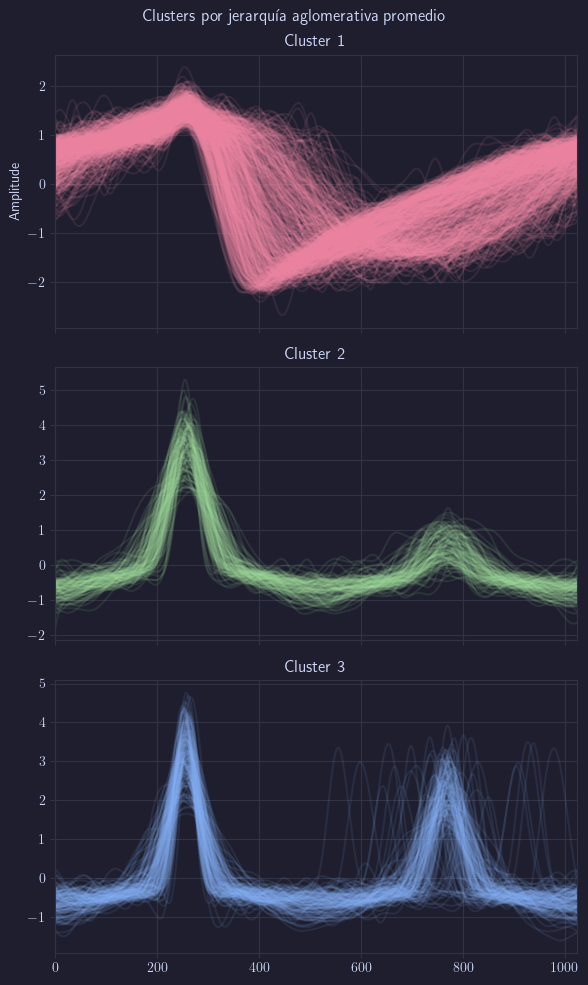

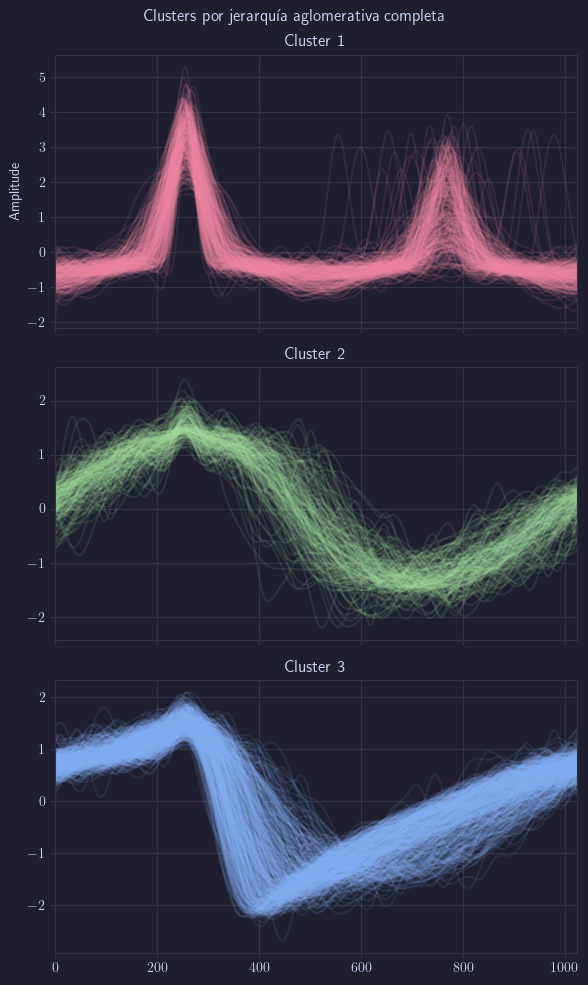

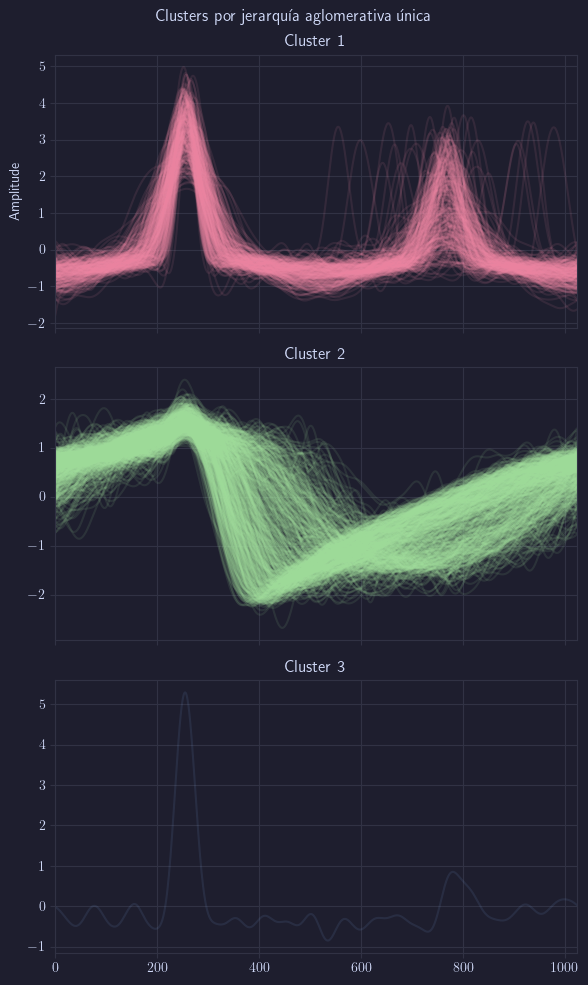

In [7]:
for name_tech, AssignedClusters in zip(AssignedClusters_tech, AssignedClusters_Opts):
    Figure, Subplot = plt.subplots(3, 1, sharex = "all", figsize=(6, 10))
    Figure.suptitle("Clusters por jerarquía aglomerativa " + name_tech)

    for class_data, time_series in zip(AssignedClusters, sample_series):
        Subplot[class_data].plot(time_series, alpha = 0.1, color = group_colors[class_data + 1])
        Subplot[class_data].set_xlim(0, 1023)
        Subplot[class_data].grid(True)

    Subplot[0].set_ylabel("Amplitude")
    for k in range(1,4):
        Subplot[k-1].set_title(f"Cluster {k}")

    Figure.tight_layout()

In [8]:
Results_Complete = GetMetricsClustering(AssignedClusters_Complete, class_series, "Jerarquico-Máximo")
Results_Single = GetMetricsClustering(AssignedClusters_Single, class_series, "Jerarquico-Mínimo")
Results_Average = GetMetricsClustering(AssignedClusters_Average, class_series, "Jerarquico-Promedio")

ResultsHierarchical = concat([Results_Average, Results_Complete, Results_Single])
ResultsHierarchical

,Rand,NMI
Jerarquico-Promedio,0.788096,0.588169
Jerarquico-Máximo,0.792424,0.608074
Jerarquico-Mínimo,0.825085,0.588169
